# Wasmer workthrough of this notebook.

This is [wasmer](https://www.fz-juelich.de/profile/wasmer_j)'s workthrough of the [original notebook](https://github.com/lab-cosmo/librascal/blob/master/examples/MLIP_example.ipynb), with additional comments, prefixed by "wasmer".

Changelog:

- 2023-01-29. wasmer. Began workthrough.

# Summary

*Update*: Seems that [librascal docs > A Gaussian approximation potential (GAP) for the Zundel cation](https://lab-cosmo.github.io/librascal/examples/zundel_i-PI.html) explains most of what is going on in this example notebook. The technique is the same, just for a different dataset. 

Note also the terminology: In rascal,
- GAP = KRR model are equivalent
- KRR model is a superset, GPR is part of it

- wasmer: on imports: okay, they use rascal implementations:
  - descriptor: `SphericalInvariants` (SOAP)
  - model: `Kernel`. I guess this is sparse GPR, not full GPR = KRR (in Deringer2021 terminology), because of the application of the `CURFilter`. More on that below.
  - feature dimension reduction:
    - `CURFilter` (CUR). CUR feature matrix decomposition, as introduced in Cersonsky2021, see references.
  - MLP: `train_gap_model` (GAP)
  - MD: `asemd`
- wasmer: on terminology:
  - in rascal, `ase.Atoms` structures are called `frames` (probably from MD)
  - they do not use `(X,y)`, but `(f,y)`. Probably for "features".
- wasmer: on dataset: OC3H6 molecules, file `molecule_conformers_dftb.xyz`.
- wasmer: on data preprocessing:
  - They load `N=100` structures, train-test split = 0.2
  - the labels are stored in the `structure`'s `info`, along with an integer `id`.
  - pipeline:
    - load `N` structures ("frames").
    - random shuffle id list
    - train-test split the structures by the id list
    - `extract_ref` converts $n$ structure's `positions` arrays, each shape `(10,3)`, into one array of shape `(10*n, 3)`, via `f = np.concatenate(f)`.
      - Question: Why that?
- wasmer: on featurization:
  - they use SOAP
  - SOAP params: rcut 3.5, nmax 6, lmax 6, sigma 0.4, rbasis GTO, some more rascal-specific SOAP params
  - rascal's SOAP descriptor `SphericalInvariants` does not return a simple numpy array, but a `rascal.neighbourlist.structure_manager.AtomsList` object, which they call `managers`.
- wasmer: on model building:
  - ...

On application of the `CURFilter`. 

This seems to do exactly what Deringer2021 describes when talking about selecting a "representative set" of $M$ features, $M < N$, to perform "real" = sparse GPR.  Let's look at the code here.

```python
# select the sparse points for the sparse kernel method with CUR on the whole training set
n_sparse = {1:40,6:30,8:20}
compressor = CURFilter(representation=soap, Nselect=n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(managers=managers)
```

In goes the `managers` (the objects holding the `N=100` train and test SOAP feature vectors), out comes an object `X_sparse`, which is not a sparse array, but of rascal type `SparsePoints`, with `size()=40+30+20=90`.

Here, they specify to use 40 samples for hydrogen, 30 samples for carbon, 20 samples for oxygen. The docs say for param `Nselect`: 

> number of points to select. If `act_on='sample per species'` then it should be a dictionary mapping atom type to the number of samples, e.g. `Nselect = {1:200,6:100,8:50}`.

I don't understand why one would do this on a per-species basis. But the sample numbers in the docs reflect somewhat the stoichiometry of the molecule, OC3H6. Perhaps that is where they pick these numbers from.


# References

This notebook as mentioned as example in the `librascal` user documentation.

On iffAiiDA `ml-base-atomistic`, it is under `/opt/librascal/examples`. Copy from there or download from repo.

Code refs.

- [librascal repo](https://github.com/lab-cosmo/librascal)
- [librascal docs](https://lab-cosmo.github.io/librascal)
  - [Fitting a model with librascal](https://lab-cosmo.github.io/librascal/user_guide/model_fitting.html)
- [scikit-cosmo docs](https://scikit-cosmo.readthedocs.io)
  - [Feature and sample selection](https://scikit-cosmo.readthedocs.io/en/latest/selection.html). CUR, FPS, and PCov extensions.
  
Literature refs.

- [Cersonsky2021](https://doi.org/10.1088/2632-2153/abfe7c). CUR, FPS, and PCov extensions.
- [Deringer2021](https://doi.org/10.1021/acs.chemrev.1c00022). "Gaussian Process Regression for Materials and Molecules".

# MLIP Example

To install rascal:
(NOTE: See the top-level README for the most up-to-date installation instructions.)
+ mkdir ../build 
+ cd build
+ cmake -DCMAKE_BUILD_TYPE=Release -DBUILD_TESTS=OFF ..
+ make -j 4
+ make install

In [1]:
%matplotlib inline
from matplotlib import pylab as plt

import time
import rascal
import json

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np

from rascal.representations import SphericalInvariants
from rascal.models import Kernel, train_gap_model
from rascal.models.asemd import ASEMLCalculator
from rascal.utils import from_dict, to_dict, CURFilter, dump_obj, load_obj, get_score, print_score

In [2]:
import urllib.request
# a collection of distorted ethanol molecules from the ANI-1 dataset 
# (see https://github.com/isayev/ANI1_dataset) with energies and forces computed using DFTB+ 
# (see https://www.dftbplus.org/)
url = 'https://raw.githubusercontent.com/lab-cosmo/librascal-example-data/833b4336a7daf471e16993158322b3ea807b9d3f/inputs/molecule_conformers_dftb.xyz'
# Download the file from `url`, save it in a temporary directory and get the
# path to it (e.g. '/tmp/tmpb48zma.txt') in the `structures_fn` variable:
structures_fn, headers = urllib.request.urlretrieve(url)
structures_fn

'/tmp/tmpne9bo5c6'

# Utility functions

In [64]:
def extract_ref(frames,info_key='dft_formation_energy_per_atom_in_eV',array_key='zeros'):
    y,f = [], [] # = y,X
    for frame in frames: # frame = ase.Atoms object
        y.append(frame.info[info_key])
        if array_key is None:
            pass
        elif array_key == 'zeros':
            f.append(np.zeros(frame.get_positions().shape))
        else:
            f.append(frame.get_array(array_key))
    y= np.array(y)
    try:
        # convert list of n_frames frames' position arrays (n_atoms, 3)
        # into one array of shape (n_frames * n_atoms, 3).
        f = np.concatenate(f)
    except:
        pass
    return y,f

# Build a Force Field

In [42]:
global_species

array([1, 6, 8])

In [4]:
# Total number of structure to load
N = 100
# Number of structure to train the model with
f = int(0.8*N)

# load the structures
frames = read(structures_fn,':{}'.format(N))


global_species = []
for frame in frames:
    global_species.extend(frame.get_atomic_numbers())
global_species = np.unique(global_species)

# split the structures in 2 sets
ids = list(range(N))
np.random.seed(10)
np.random.shuffle(ids)

train_ids = ids[:f]
test_ids = ids[f:]

frames_train = [frames[ii] for ii in ids[:f]]
frames_test = [frames[ii] for ii in ids[f:]]

# Isolated atom contributions
self_contributions = {
    1: -6.492647589968434,
    6: -38.054950840332474,
    8: -83.97955098636527,
}

In [5]:
print(global_species)
frames_test

[1 6 8]


[Atoms(symbols='OC3H6', pbc=False, cell=[6.0, 6.0, 6.0], dftb_forces_eV_per_Ang=..., forces=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OC3H6', pbc=False, cell=[6.0, 6.0, 6.0], dftb_forces_eV_per_Ang=..., forces=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OC3H6', pbc=False, cell=[6.0, 6.0, 6.0], dftb_forces_eV_per_Ang=..., forces=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OC3H6', pbc=False, cell=[6.0, 6.0, 6.0], dftb_forces_eV_per_Ang=..., forces=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OC3H6', pbc=False, cell=[6.0, 6.0, 6.0], dftb_forces_eV_per_Ang=..., forces=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OC3H6', pbc=False, cell=[6.0, 6.0, 6.0], dftb_forces_eV_per_Ang=..., forces=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OC3H6', pbc=False, cell=[6.0, 6.0, 6.0], dftb_forces_eV_per_Ang=..., forces=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OC3H6', pbc=False, cell=[

In [44]:
structure = frames_test[0]
structure.info

{'index': 49,
 'energy': -290.8329523893519,
 'dftb_energy_eV': -290.8329523893519,
 'pos_unit': 'angstrom'}

In [42]:
import ase.visualize
ase.visualize.view(structure, viewer='x3d')

In [8]:
# split the dataset in a train and a test set
y_train, f_train = extract_ref(frames_train,'dftb_energy_eV','dftb_forces_eV_per_Ang')
y_test, f_test = extract_ref(frames_test,'dftb_energy_eV','dftb_forces_eV_per_Ang')

In [9]:
# define the parameters of the spherical expansion
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=False,
              radial_basis="GTO",
              compute_gradients=True,
              expansion_by_species_method='structure wise',
              )


soap = SphericalInvariants(**hypers)
# compute the representation of all the structures
managers = soap.transform(frames)

In [10]:
soap

In [11]:
managers

In [13]:
# select the sparse points for the sparse kernel method with CUR on the whole training set
n_sparse = {1:40,6:30,8:20}
compressor = CURFilter(representation=soap, Nselect=n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(managers=managers)

In [73]:
print(f"{N=}\n{len(managers)=}\n{sum(n_sparse.values())=}\n{X_sparse.size()=}")

N=100
len(managers)=100
sum(n_sparse.values())=90
X_sparse.size()=90


In [14]:
# set up the sparse kernel and compute the representation for the train set
zeta = 1
kernel = Kernel(representation=soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

managers_train = managers.get_subset(train_ids)

In [82]:
managers_train.get_features(calculator=soap).shape

(800, 1512)

In [88]:
features_by_species = managers_train.get_features_by_species(calculator=soap)
print(f"{features_by_species.keys()=}")
{atom_pair: fv.shape for atom_pair, fv in features_by_species.items()}

features_by_species.keys()=dict_keys([(1, 1), (1, 6), (1, 8), (6, 6), (6, 8), (8, 8)])


{(1, 1): (800, 252),
 (1, 6): (800, 252),
 (1, 8): (800, 252),
 (6, 6): (800, 252),
 (6, 8): (800, 252),
 (8, 8): (800, 252)}

In [24]:
managers_train.nl_options

[{'name': 'centers', 'args': []},
 {'name': 'neighbourlist', 'args': {'cutoff': 3.5}},
 {'name': 'centercontribution', 'args': {}},
 {'name': 'strict', 'args': {'cutoff': 3.5}}]

In [26]:
# build the KNM matrix for training with forces and energies (see train_gap_model for more details)
KNM = kernel(X=managers_train, Y=X_sparse)
KNM_down = kernel(X=managers_train, Y=X_sparse, grad=(True, False))
KNM = np.vstack([KNM, KNM_down])
del KNM_down
KNM_down = []


In [27]:
# train a GAP model 
model = train_gap_model(kernel=kernel, frames=frames_train, KNM_=KNM, X_sparse=X_sparse, y_train=y_train, self_contributions=self_contributions, 
                        grad_train=-f_train, lambdas=[0.1, 0.01], jitter=1e-13)

/opt/aiida-kernel/lib/python3.8/site-packages/rascal/models/krr.py:656: UserWarning: Warning solver = lstsq and rcond=None is deprecated.            Use an other solver or rcond=-1
  warnings.warn(


In [ ]:
# # the model can be serialized to a python dictionary
# model_serialized = to_dict(model)
# # and recovered from such dictionary
# model_copy = from_dict(model_serialized)

In [28]:
# make predictions on the test set
managers_test = managers.get_subset(test_ids)
y_pred = model.predict(managers_test)
f_pred = model.predict_forces(managers_test)

MAE=5.14e+01 RMSE=5.14e+01 SUP=5.20e+01 R2=-3.55e+03 CORR=9.35e-01
MAE=7.14e-01 RMSE=1.10e+00 SUP=5.68e+00 R2=1.94e-01 CORR=3.81e-01


Text(0, 0.5, 'reference energies [eV]')

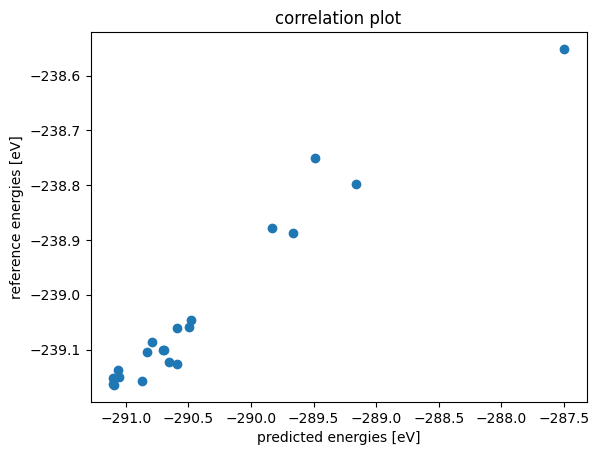

In [29]:
# basic assessement of the quality of the trained model
print_score(y_pred, y_test)
print_score(f_pred.flatten(), f_test.flatten())
plt.plot(y_test, y_pred, 'o')
plt.title("correlation plot")
plt.xlabel("predicted energies [eV]")
plt.ylabel("reference energies [eV]")

The correlation isn't great, but it's enough to get a working potential.

In order to improve the accuracy and start getting _quantitative_ accuracy, we would need to increase the number of sparse environments (`n_sparse` above), as well as the number of training structures, both of which would also require more memory and time to train.  Be aware that you can easily exceed the memory limits even of typical supercomputer nodes with just a few hundred sparse points and a few thousand training atoms!

In [30]:
# save the model to a file in json format for future use
dump_obj('/tmp/mymodel.json', model)

# Test the model on dimer configurations

In [31]:
# you can load the previously trained model
model = load_obj('/tmp/mymodel.json')

In [32]:
#creating atoms pairs, H is 1, C is 6 and O is 8, the first atom is the origin one
pairs = [[1,1],[6,6],[8,8],[6,1],[8,1],[6,8]]
ndists = 40 #number of distances to look at
dists = np.linspace(0.1,4.9,ndists) #distance list, can be changed 
print('Number of configurations: ', len(pairs)*len(dists))

Number of configurations:  240


In [33]:
frames = []
for p in pairs:
    for d in dists:
        #using ase we can create the cell and place the atoms
        atoms = ase.Atoms(numbers=p,pbc=False,cell=np.eye(3)*10,positions=[[0,0,0],[d,0,0]])
        frames.append(atoms)
X = soap.transform(frames)
e_pairs = model.predict(X)
e_pairs -= e_pairs.mean()

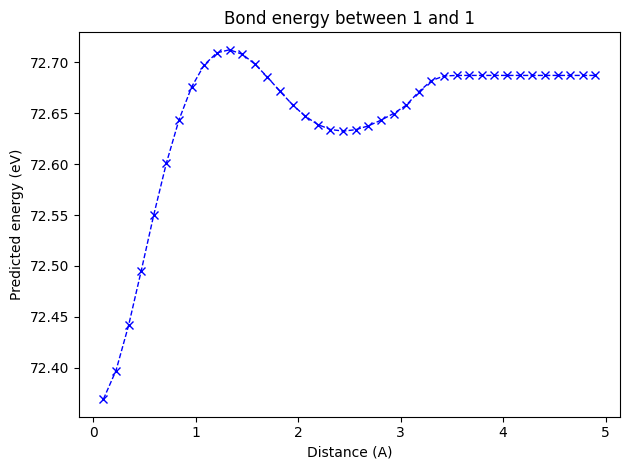

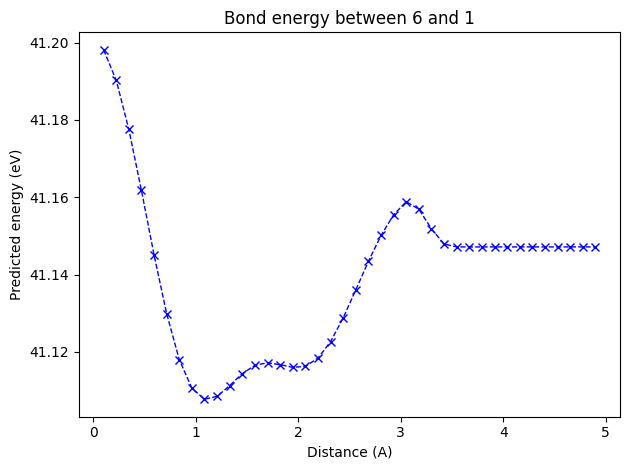

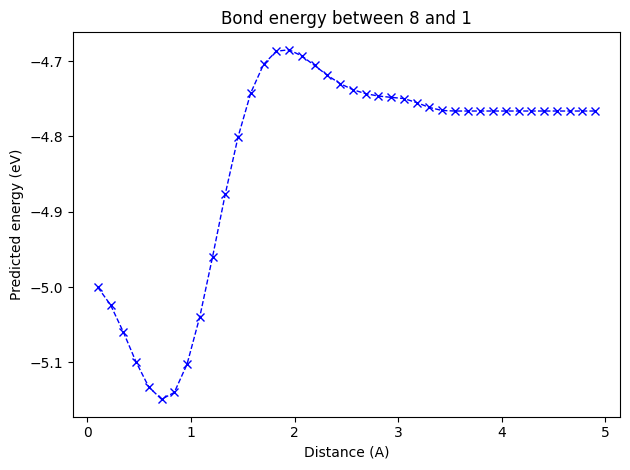

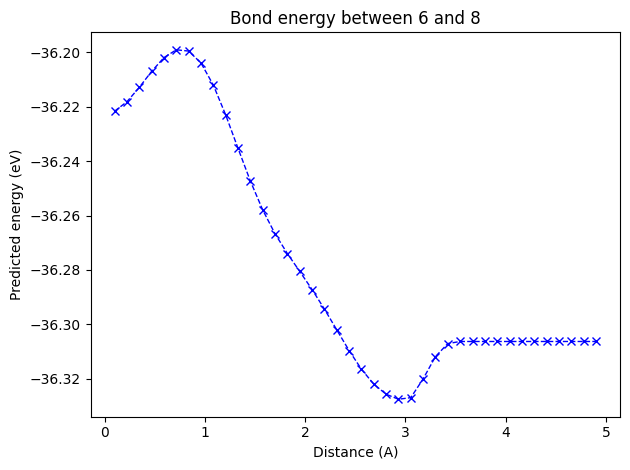

In [34]:
for pair_to_plot in pairs:
    i = pairs.index(pair_to_plot)

    fig, ax = plt.subplots()
    ax.plot(dists,e_pairs[i*ndists:(i+1)*ndists],'--xb',linewidth=1)
    ax.set_xlabel('Distance (A)')
    ax.set_ylabel('Predicted energy (eV)')
    ax.set_title('Bond energy between {} and {}'.format(*pair_to_plot))
    plt.tight_layout()
    plt.show()

# Use it to run a MD simulation

In [35]:
from ase.md import MDLogger
from ase.md.langevin import Langevin
from ase import units
from ase.io.trajectory import Trajectory
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution

In [36]:
from rascal.models.asemd import ASEMLCalculator

In [37]:
# Use the model loaded above
soap = model.get_representation_calculator()
calc = ASEMLCalculator(model, soap)

In [38]:
log_fn = '/tmp/md.log'
filename = '/tmp/md.traj'

T = 200

In [39]:
%%time

atoms = read(structures_fn, 0)

MaxwellBoltzmannDistribution(atoms, T* units.kB)

atoms.set_calculator(calc)

traj = Trajectory(filename, mode='w', atoms=atoms, master=None)

dyn = Langevin(atoms, 0.5 * units.fs, units.kB * T, 0.002)

dyn.attach(MDLogger(dyn, atoms, log_fn, header=True, stress=False,
           peratom=False, mode="w"), interval=50)

dyn.attach(traj.write, interval=10)

dyn.run(200)

/opt/aiida-kernel/lib/python3.8/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


CPU times: user 4.48 s, sys: 16.9 s, total: 21.4 s
Wall time: 2.18 s


True

Uncomment and run the cell below to examine the trajectory using the ASE viewer:

In [40]:
view(read(filename,':'))

usage: ase [-h] [--version] [-T]
           {help,info,test,gui,db,run,band-structure,build,dimensionality,eos,ulm,find,nebplot,nomad-upload,nomad-get,convert,reciprocal,completion,diff,exec}
           ...
ase: error: TclError: no display name and no $DISPLAY environment variable
To get a full traceback, use: ase -T gui ...


In [41]:
ase.visualize.view(read(filename, ':'), viewer='x3d')

AttributeError: 'list' object has no attribute 'write'